In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Activation,Dropout,Bidirectional,TimeDistributed
from tensorflow import keras
import tensorflow as tf
import keras_tuner as kt
from sklearn.metrics import fbeta_score, confusion_matrix, ConfusionMatrixDisplay


In [3]:
# I used Google Chrome whilst working in Google Colab so I was able to complete this step by recieving the authorisation code after logging into my gmail account.
# Users may need to also use Google Chrome to run this code and connect via the browser to your gmail when prompted.

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load the dataset

In [4]:
from google.colab import files
import io
uploaded = files.upload()

Saving dataset.csv to dataset.csv


In [5]:
df = pd.read_csv(io.BytesIO(uploaded['dataset.csv']), header=None)

In [6]:
#df = pd.read_csv('dataset.csv', header=None)

df.columns = ['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume (ETH)', 'Close Time', 'Quote Asset Volume (USDT)', 
              'No. of trades', 'Buy Base Volume (ETH)', 'Buy Quote Volume (USDT)', 'Ignore']

# Preprocessing steps 
##### (Explained in the workbook titled 'Exploratory Data Analysis & Preprocessing)

In [7]:
df['Open Date'] = pd.to_datetime(df['Open Time'], unit='ms')

In [8]:
df['Close Date'] = pd.to_datetime(df['Close Time'], unit='ms')

In [9]:
df['Close Date'] = df['Close Date'].dt.normalize()

In [10]:
df.drop(['Open Time', 'Close Time'], axis=1, inplace=True)

In [11]:
df.drop(['Ignore', 'Volume (ETH)', 'No. of trades', 'Buy Base Volume (ETH)', 'Buy Quote Volume (USDT)', 'Open Date'], axis=1, inplace=True)

In [12]:
df.rename(columns = {'Quote Asset Volume (USDT)':'Volume'}, inplace = True)

In [13]:
df.set_index('Close Date', inplace=True)
df.head()

,Open,High,Low,Close,Volume
Close Date,,,,,
2017-08-17,301.13,312.18,298.00,302.00,2.154655e+06
2017-08-18,302.00,311.79,283.94,293.96,2.858947e+06
2017-08-19,293.31,299.90,278.00,290.91,6.200226e+05
2017-08-20,289.41,300.53,282.85,299.10,7.428479e+05
2017-08-21,299.10,346.52,294.60,323.29,1.689472e+06


In [14]:
columns = df.columns.tolist()
columns = columns[-1:] + columns[:-1]
df = df[columns]

In [15]:
df.head()

,Volume,Open,High,Low,Close
Close Date,,,,,
2017-08-17,2.154655e+06,301.13,312.18,298.00,302.00
2017-08-18,2.858947e+06,302.00,311.79,283.94,293.96
2017-08-19,6.200226e+05,293.31,299.90,278.00,290.91
2017-08-20,7.428479e+05,289.41,300.53,282.85,299.10
2017-08-21,1.689472e+06,299.10,346.52,294.60,323.29


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1412 entries, 2017-08-17 to 2021-06-28
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Volume  1412 non-null   float64
 1   Open    1412 non-null   float64
 2   High    1412 non-null   float64
 3   Low     1412 non-null   float64
 4   Close   1412 non-null   float64
dtypes: float64(5)
memory usage: 66.2 KB


# Create classes

In [17]:
# create a column to indicate the price movement: 1 means the price has increased compared to the previous day, 0 means the price has decreased

movement = []

for i in range(len(df)-1):

  if df['Close'][i+1] < df['Close'][i]:
    movement.append(0)
  
  else:
    movement.append(1)


In [18]:
# datapoint 0 in the dataset (2017-08-17) will be dropped because there is no price information prior to this day so it can not be put into a class.
df.drop(df.index[0], inplace=True)
df.head()

,Volume,Open,High,Low,Close
Close Date,,,,,
2017-08-18,2.858947e+06,302.00,311.79,283.94,293.96
2017-08-19,6.200226e+05,293.31,299.90,278.00,290.91
2017-08-20,7.428479e+05,289.41,300.53,282.85,299.10
2017-08-21,1.689472e+06,299.10,346.52,294.60,323.29
2017-08-22,2.454426e+06,321.04,330.41,144.21,309.80


In [19]:
df['Price Movement'] = np.array(movement)

In [20]:
df

,Volume,Open,High,Low,Close,Price Movement
Close Date,,,,,,
2017-08-18,2.858947e+06,302.00,311.79,283.94,293.96,0
2017-08-19,6.200226e+05,293.31,299.90,278.00,290.91,0
2017-08-20,7.428479e+05,289.41,300.53,282.85,299.10,1
2017-08-21,1.689472e+06,299.10,346.52,294.60,323.29,1
2017-08-22,2.454426e+06,321.04,330.41,144.21,309.80,0
...,...,...,...,...,...,...
2021-06-24,1.377800e+09,1967.95,2036.61,1884.79,1989.52,1
2021-06-25,1.612557e+09,1989.53,2019.99,1791.22,1808.82,0
2021-06-26,1.478551e+09,1808.97,1852.80,1717.32,1829.64,1


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1411 entries, 2017-08-18 to 2021-06-28
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Volume          1411 non-null   float64
 1   Open            1411 non-null   float64
 2   High            1411 non-null   float64
 3   Low             1411 non-null   float64
 4   Close           1411 non-null   float64
 5   Price Movement  1411 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 77.2 KB


# Split dataset into training, validation and testing datasets

#### I will now split the timeseries into training and test sets, before I scale it to prevent data leakage. https://machinelearningmastery.com/machine-learning-data-transforms-for-time-series-forecasting/
#### I'll be splitting the data into three sets (Training, Validation and Test)  as per the holdout method to help with determining the generalisation ability of the model during model selection. 
#### 61.45% of the data will be used for training, 12.7% will be used as the validation set and the remaining 25.85% will be used as the test set

In [22]:
split = int(len(df)*0.6145)
training_set = df[:split]      # 18/8/2017 - 1/1/2020

subset = df[split:]
split2 = int(len(subset)*0.3303)

val_set = subset[:split2]      # 2/1/2020 - 28/6/2020
test_set = subset[split2:]     # 29/6/2020 - 28/6/2021

In [23]:
print('Training: ', training_set.shape, '\nValidation: ', val_set.shape, '\nTest: ', test_set.shape)

Training:  (867, 6) 
Validation:  (179, 6) 
Test:  (365, 6)


# Split the data into X variables and y targets

In [24]:
# the x values will contain the first 5 features in the dataset and the y value will contain only the target feature to predict (price movement) 

X_training = (training_set.iloc[:, :-1]).values.reshape(training_set.shape[0],training_set.shape[1]-1)
y_training = (training_set.iloc[:, -1]).values.reshape(training_set.shape[0],1)

print(X_training.shape, y_training.shape)

X_valid = (val_set.iloc[:, :-1]).values.reshape(val_set.shape[0],val_set.shape[1]-1)
y_valid = (val_set.iloc[:, -1]).values.reshape(val_set.shape[0],1)

print(X_valid.shape, y_valid.shape)

X_testing = (test_set.iloc[:, :-1]).values.reshape(test_set.shape[0],test_set.shape[1]-1)
y_testing = (test_set.iloc[:, -1]).values.reshape(test_set.shape[0],1)

print(X_testing.shape, y_testing.shape)

(867, 5) (867, 1)
(179, 5) (179, 1)
(365, 5) (365, 1)


# I will check how imbalanced the classes are in each of the datasets' target vectors. 
###I am following a Keras tutorial on how to check for and deal with imbalanced class sizes when training neural networks for classification tasks:
https://keras.io/examples/structured_data/imbalanced_classification/


In [25]:
print('TRAINING SET\n', 'Count:\n', training_set['Price Movement'].value_counts(), '\n\nRelative Frequencies:\n',training_set['Price Movement'].value_counts(normalize=True))
print('\nVALIDATION SET\n', 'Count:\n', val_set['Price Movement'].value_counts(), '\n\nRelative Frequencies:\n',val_set['Price Movement'].value_counts(normalize=True))
print('\nTESTING SET\n', 'Count:\n', test_set['Price Movement'].value_counts(), '\n\nRelative Frequencies:\n',test_set['Price Movement'].value_counts(normalize=True))



TRAINING SET
 Count:
 0    445
1    422
Name: Price Movement, dtype: int64 

Relative Frequencies:
 0    0.513264
1    0.486736
Name: Price Movement, dtype: float64

VALIDATION SET
 Count:
 1    92
0    87
Name: Price Movement, dtype: int64 

Relative Frequencies:
 1    0.513966
0    0.486034
Name: Price Movement, dtype: float64

TESTING SET
 Count:
 1    213
0    152
Name: Price Movement, dtype: int64 

Relative Frequencies:
 1    0.583562
0    0.416438
Name: Price Movement, dtype: float64


In [26]:
class_labels = pd.unique(df['Price Movement'])

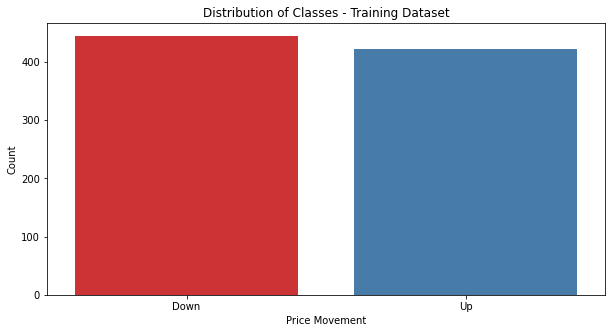

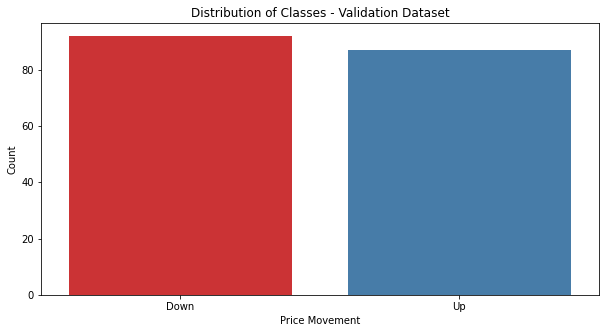

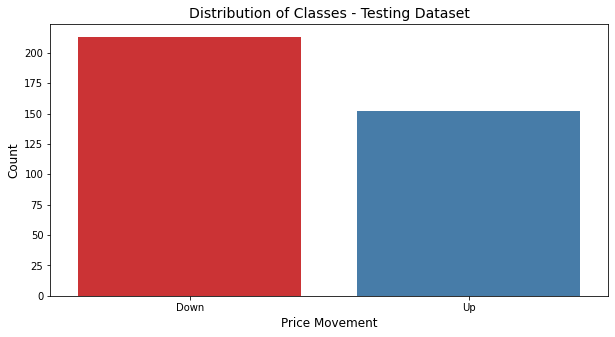

In [27]:
plt.figure(figsize = (10, 5))
sns.barplot(x = ['Down', 'Up'], y= training_set['Price Movement'].value_counts(), palette='Set1')
plt.title('Distribution of Classes - Training Dataset')
plt.xlabel("Price Movement")
plt.ylabel("Count")
plt.show()

plt.figure(figsize = (10, 5))
sns.barplot(x = ['Down', 'Up'], y= val_set['Price Movement'].value_counts(), palette='Set1')
plt.title('Distribution of Classes - Validation Dataset')
plt.xlabel("Price Movement")
plt.ylabel("Count")
plt.show()

plt.figure(figsize = (10, 5))
sns.barplot(x = ['Down', 'Up'], y= test_set['Price Movement'].value_counts(), palette='Set1')
plt.title('Distribution of Classes - Testing Dataset', fontsize=14)
plt.xlabel("Price Movement", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

# Normalisation

#### The values need to be scaled to between 0 and 1 so I will use MinMaxScaler from scikit-learn to do this.
#### https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

In [28]:
Xscaler = MinMaxScaler(feature_range=(0,1))
yscaler = MinMaxScaler(feature_range=(0,1))

X_train = Xscaler.fit_transform(X_training)
y_train = yscaler.fit_transform(y_training)

X_val = Xscaler.fit_transform(X_valid)
y_val = yscaler.fit_transform(y_valid)

X_test = Xscaler.fit_transform(X_testing)
y_test = yscaler.fit_transform(y_testing)

## Prepare data for multi-step LSTM
##### source code: https://pangkh98.medium.com/multi-step-multivariate-time-series-forecasting-using-lstm-92c6d22cd9c2

In [29]:
# stack the data horizontally

train_stacked = np.hstack((X_training, y_training))
print ("Stacked Training Data Shape: " , train_stacked.shape)

val_stacked = np.hstack((X_valid, y_valid))
print ("Stacked Validation Data Shape: " , val_stacked.shape)

test_stacked = np.hstack((X_testing, y_testing))
print ("Stacked Test Data Shape: " , test_stacked.shape)

Stacked Training Data Shape:  (867, 6)
Stacked Validation Data Shape:  (179, 6)
Stacked Test Data Shape:  (365, 6)


In [30]:
# create sequences (n_steps_in = input timesteps, n_steps_out = output timesteps)

def create_sequences(sequences, n_steps_in, n_steps_out):
 X, y = [], []

 for i in range(len(sequences)):

  # find the end of this pattern
  end_ix = i + n_steps_in
  out_end_ix = end_ix + n_steps_out-1

  # check if we are beyond the dataset
  if out_end_ix > len(sequences):
   break

  # gather input and output parts of the pattern
  seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
  X.append(seq_x)
  y.append(seq_y)
 return np.array(X), np.array(y)

   

In [31]:
# choose a number of time steps 
n_steps_in, n_steps_out = 14, 14

# run function
X_train, y_train = create_sequences(train_stacked, n_steps_in, n_steps_out)
print ("X train sequences: " , X_train.shape, "y train sequences" , y_train.shape)            

X_val, y_val = create_sequences(val_stacked, n_steps_in, n_steps_out)
print ("X val sequences: " , X_val.shape, "y val sequences" , y_val.shape) 

X_test, y_test = create_sequences(test_stacked, n_steps_in, n_steps_out)
print ("X test sequences: " , X_test.shape, "y test sequences" , y_test.shape)      

X train sequences:  (841, 14, 5) y train sequences (841, 14)
X val sequences:  (153, 14, 5) y val sequences (153, 14)
X test sequences:  (339, 14, 5) y test sequences (339, 14)


# Model Building on CoLab
### I will tune the model using Keras Tuner

##### https://www.danielpovey.com/files/2017_interspeech_dropout.pdf 
##### https://www.tensorflow.org/tutorials/keras/keras_tuner#define_the_model
##### Using Bidirectional wrappers to create a Bidirectional LSTM: https://keras.io/api/layers/recurrent_layers/bidirectional/
##### Code for classification Bidirectional LSTM adapted from: https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/

In [32]:
n_features = X_train.shape[2]

# I need to define the features during model creation so that the Keras Tuner can find the optimum values

# create LSTM model
def create_model(hp):

  model = Sequential()
  # Tuner for number of nodules/units in the model layers
  model.add(Bidirectional(LSTM(units=hp.Int('units', min_value=10, max_value=100, step=10), activation='relu', return_sequences=True), input_shape=(n_steps_in, n_features),
                          merge_mode=hp.Choice('merge_mode', values=['sum', 'mul', 'concat', 'ave'])))
 
  for i in range(hp.Int('n_layers', 1, 3)):  # adding additional layers.
    model.add(Bidirectional(LSTM(units=hp.Int('units', min_value=10, max_value=100, step=10), activation='relu', return_sequences=True), 
            merge_mode=hp.Choice('merge_mode', values=['sum', 'mul', 'concat', 'ave'])))
    model.add(Dropout(hp.Choice('dropout', values=[0.3, 0.5, 0.7])))

  model.add(Bidirectional(LSTM(units=hp.Int('units', min_value=10, max_value=100, step=10), activation='relu', return_sequences=True), 
            merge_mode=hp.Choice('merge_mode', values=['sum', 'mul', 'concat', 'ave'])))
  model.add(Dropout(hp.Choice('dropout', values=[0.3, 0.5, 0.7])))
  model.add(TimeDistributed(Dense(1, activation='sigmoid')))
  model.compile(loss='binary_crossentropy' , optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])) , metrics=['accuracy'])

  return model




# Hypertune the model

In [33]:
# I need to set up the tuner with the correct objective function which in this case is to minimise the validation loss (i.e. the generalisation error)

tuner = kt.RandomSearch(create_model, objective = "val_accuracy", max_trials=10)

# Search for the best parameters

In [34]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
units (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 100, 'step': 10, 'sampling': None}
merge_mode (Choice)
{'default': 'sum', 'conditions': [], 'values': ['sum', 'mul', 'concat', 'ave'], 'ordered': False}
n_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
dropout (Choice)
{'default': 0.3, 'conditions': [], 'values': [0.3, 0.5, 0.7], 'ordered': True}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [35]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10)

In [36]:
# The tuner will now search across the potential values for each hyperparameter and select the best combination

tuner.search(X_train , y_train , epochs=100 , validation_data=(X_val, y_val)  ,shuffle=False, callbacks=[stop_early])

Trial 10 Complete [00h 00m 53s]
val_accuracy: 0.498132586479187

Best val_accuracy So Far: 0.5298786163330078
Total elapsed time: 00h 08m 42s
INFO:tensorflow:Oracle triggered exit


# Results of hypertuning

In [37]:
# This will provide a list of the top 10 best models in ascending order, with their respective parameters. 
# Model 1 at the top of the list is the optimised model that I will use for training and testing.

tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
units: 20
merge_mode: sum
n_layers: 2
dropout: 0.3
learning_rate: 0.001
Score: 0.5298786163330078
Trial summary
Hyperparameters:
units: 30
merge_mode: ave
n_layers: 2
dropout: 0.5
learning_rate: 0.001
Score: 0.5289449095726013
Trial summary
Hyperparameters:
units: 70
merge_mode: ave
n_layers: 3
dropout: 0.3
learning_rate: 0.0001
Score: 0.5284780859947205
Trial summary
Hyperparameters:
units: 30
merge_mode: concat
n_layers: 2
dropout: 0.3
learning_rate: 0.01
Score: 0.527544379234314
Trial summary
Hyperparameters:
units: 90
merge_mode: sum
n_layers: 2
dropout: 0.5
learning_rate: 0.01
Score: 0.5042017102241516
Trial summary
Hyperparameters:
units: 90
merge_mode: concat
n_layers: 2
dropout: 0.7
learning_rate: 0.01
Score: 0.498132586479187
Trial summary
Hyperparameters:
units: 40
merge_mode: sum
n_layers: 2
dropout: 0.5
learning_rate: 0.001
Scor

In [38]:
best_model = tuner.get_best_models(num_models=1)[0]

In [39]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 14, 20)            4160      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 14, 20)            6560      
_________________________________________________________________
dropout (Dropout)            (None, 14, 20)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 14, 20)            6560      
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 20)            0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 14, 20)            6560      
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 20)            0

# Train model 


In [40]:
# fit model
best_model.fit(X_train , y_train , epochs=100 , verbose=0 , validation_data=(X_val, y_val) ,shuffle=False)


# Test the model on test dataset

Test Accuracy:  54.300000000000004 || Test F-score:  0.615 



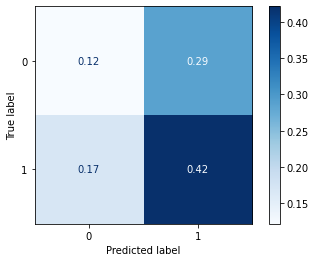

In [41]:
# generate the test predictions 

test_pred = best_model.predict(X_test)

# generate the metric scores

y_test = y_test.reshape(y_test.shape[0], y_test.shape[1])

test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose = 0)

test_pred = test_pred.astype(int).reshape(-1)
y_test = y_test.astype(int).reshape(-1)

fscore = fbeta_score(y_test, test_pred, beta=0.5)

print('Test Accuracy: ', float('%.3g' % test_accuracy)*100, '|| Test F-score: ', float('%.3g' % fscore), '\n')

matrix = confusion_matrix(y_test, test_pred, normalize='all')
matrix_image = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=[0,1])
matrix_image.plot(cmap='Blues') 



In [42]:
# saving the model so that it can be loaded in a later notebook to compare against the models with different inputs

best_model.save('/content/drive/My Drive/Classification model/classification_model')

INFO:tensorflow:Assets written to: /content/drive/My Drive/Classification model/classification_model/assets
